# Violent and Sexual Crime in Amsterdam 2018

In [1]:
# Libararies
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import mapclassify
%matplotlib inline

## Data & Pre-processing

### Data about registered violent and sexual crime
The data is sourced from the Centraal Bureau voor de Statistiek, Den Haag/Heerlen and can be accessed from https://opendata.cbs.nl/statline/portal.html?_la=nl&_catalog=CBS&tableId=84468NED&_theme=395.

In [2]:
# Access the raw crime data 
df = pd.read_csv(r'C:\Users\murat\OneDrive\Belgeler\Projects\NL crime\84468NED_TypedDataSet_30122020_144308.csv', sep=';' , index_col=[0])

In [3]:
# Remove white spaces from the categorical data
df['WijkenEnBuurten'] = df['WijkenEnBuurten'].str.strip()
df['Gemeentenaam_1'] = df['Gemeentenaam_1'].str.strip()

In [4]:
# Rename column names
columns_to_rename = {
'WijkenEnBuurten': 'Neighborhood',
'Gemeentenaam_1': 'Municipality', 
'SoortRegio_2' : 'Region_type', 
'Codering_3': 'Code',
'Indelingswijziging_4' :'Classification_change', 
'AantalInwoners_5': 'Inhabitants',
'TotaalVermogenVernielingEnGeweld_6': 'Total_assets_destruction_and_violence', 
'TotaalVermogensmisdrijven_7': 'Total Property Crimes',
'TotaalDiefstal_8' : 'Total theft',
'Fietsendiefstal_9' : 'Bicycle theft',
'DiefstalOverigeVervoermiddelen_10': 'Theft_of_other_means_of_transport',
'DiefstalUitVanafVervoermiddelen_11': 'Theft From Means of Transport',
'ZakkenrollerijStraatroofEnBeroving_12': 'Pickpocketing_street_robbery_and_robbery',
'TotaalDiefstalUitWoningSchuurED_13' : 'Total_theft_from_house_and_yard',
'DiefstalUitNietResidentieleGebouwen_14': 'TheftOutNotResidentialBuildings', 
'OverigeDiefstalInbraak_15': 'Other_theft_burglary',
'OverigeVermogensmisdrijven_16': 'Other_property_crimes', 
'TotaalVernielingTegenOpenbareOrde_17': 'Total_destruction_against_public_order',
'TotaalVernieling_18': 'Total_destruction', 
'VernielingAanAuto_19': 'Destruction_to_car', 
'OverigeVernieling_20': 'Other_destruction',
'OverigeVernielingTegenOpenbareOrde_21': 'Other_destruction_against_public_order',
'TotaalGeweldsEnSeksueleMisdrijven_22': 'Total_violence_and_sexual_crimes',
'Mishandeling_23' : 'Mistreatment',
'BedreigingEnStalking_24' : 'Threats_and_stalking', 
'OverigeGeweldsEnSeksueleMisdrijven_25': 'Other_violence_and_sexual_crimes',
'TotaalVermogenVernielingEnGeweld_26': 'Total_assets_destruction_and_violence', 
'TotaalVermogensmisdrijven_27': 'Total_property_crimes',
'TotaalDiefstalUitWoningSchuurED_28' : 'Total_theft_from_home_and_shed',
'VernielingMisdrijfTegenOpenbareOrde_29' : 'Destruction_crime_against_public_order',
'GeweldsEnSeksueleMisdrijven_30': 'Violent_and_sexual_crimes'}

df_en = df.rename(columns=columns_to_rename)

In [5]:
# Drop rows that contain redundent information for the future calculation
df_en.drop(df_en[df_en['Neighborhood'].str.contains('WK')].index, inplace = True)
df_en.drop(df_en[df_en['Neighborhood'].str.contains('GM')].index, inplace = True)

In [6]:
# Filter the data
df_amsterdam_full = df_en.loc[df_en["Municipality"].isin(['Amsterdam'])]

In [7]:
# Drop columns
df_amsterdam = df_amsterdam_full.drop(['Municipality', 'Region_type', 'Code',
       'Classification_change', 'Total_assets_destruction_and_violence', 'Total Property Crimes',
       'Total theft', 'Bicycle theft', 'Theft_of_other_means_of_transport',
       'Theft From Means of Transport',
       'Pickpocketing_street_robbery_and_robbery',
       'Total_theft_from_house_and_yard', 'TheftOutNotResidentialBuildings',
       'Other_theft_burglary', 'Other_property_crimes',
       'Total_destruction_against_public_order', 'Total_destruction',
       'Destruction_to_car', 'Other_destruction',
       'Other_destruction_against_public_order', 'Mistreatment',
       'Threats_and_stalking', 'Other_violence_and_sexual_crimes',
       'Total_assets_destruction_and_violence', 'Total_property_crimes',
       'Total_theft_from_home_and_shed',
       'Destruction_crime_against_public_order', 'Violent_and_sexual_crimes'], axis=1)

### Data for geographic information
The data is accessed from www.pdok.nl for the official district boundaries of the Netherlands in 2018

In [8]:
# Load the geographic data
zipfile = "zip:///Users/murat/OneDrive/Belgeler/Projects/NL crime/WijkBuurtkaart_2018_v3.zip"
geodata = gpd.read_file(zipfile)
geodata.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 13404 entries, 0 to 13403
Columns: 201 entries, BU_CODE to geometry
dtypes: float64(96), geometry(1), int64(97), object(7)
memory usage: 20.6+ MB


In [9]:
# Prepare the geographic data for merging:
## Clean white space and change data type from object to string 
geodata['GM_NAAM'] = geodata['GM_NAAM'].str.strip()
geodata["GM_NAAM"] = geodata["GM_NAAM"].astype('str')
geodata['BU_NAAM'] = geodata['BU_NAAM'].str.strip()
geodata["BU_NAAM"] = geodata["BU_NAAM"].astype('str')

In [10]:
# Filter the data for mapping Amsterdam
geodata_amsterdam = geodata[geodata['GM_NAAM'] == 'Amsterdam']
geodata_amsterdam.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 480 entries, 26 to 4764
Columns: 201 entries, BU_CODE to geometry
dtypes: float64(96), geometry(1), int64(97), object(7)
memory usage: 757.5+ KB


### Merge Data

In [11]:
# Join the geodataframe with the cleaned up csv dataframe
merged = geodata_amsterdam.set_index('BU_CODE').join(df_amsterdam.set_index('Neighborhood'))

In [12]:
# Change column name in the final dataframe
merged = merged.rename(columns={'BU_NAAM': 'Neigborhood'})
merged.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 480 entries, BU03639997 to BU03639801
Columns: 202 entries, Neigborhood to Total_violence_and_sexual_crimes
dtypes: float64(98), geometry(1), int64(97), object(6)
memory usage: 781.2+ KB


In [13]:
merged = merged[merged['WATER'] == 'NEE']
merged.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 479 entries, BU03630000 to BU03639801
Columns: 202 entries, Neigborhood to Total_violence_and_sexual_crimes
dtypes: float64(98), geometry(1), int64(97), object(6)
memory usage: 779.7+ KB


In [14]:
merged.to_file("amsterdam_neighborhoods.shp")

In [15]:
merged.Total_violence_and_sexual_crimes.describe()

count    473.000000
mean      15.832981
std       17.516083
min        0.000000
25%        5.000000
50%       11.000000
75%       20.000000
max      143.000000
Name: Total_violence_and_sexual_crimes, dtype: float64

## Analysis

### Neighborhoods  with the highest numbers of crime in Amsterdam

In [16]:
# Display the neighborhoods with the highest number of records of violent and sexual crime
table = merged.groupby('Neigborhood')['Total_violence_and_sexual_crimes'].sum().sort_values(ascending=False)
table = pd.DataFrame(table)
print(table.head(10))
print('-------------------------------------------------------')
print("Number of Neighborhood                         : ", len(table))
print("Total number of records in Amsterdam           :", table.Total_violence_and_sexual_crimes.values.sum())

                       Total_violence_and_sexual_crimes
Neigborhood                                            
Stationsplein e.o.                                143.0
Amsterdamse Poort                                 131.0
Leidsebuurt Noordoost                             125.0
Leidsebuurt Noordwest                              94.0
Van der Pekbuurt                                   84.0
Burgwallen Oost                                    84.0
Rembrandtpleinbuurt                                83.0
Reguliersbuurt                                     70.0
Oude Kerk e.o.                                     69.0
K-buurt Midden                                     65.0
-------------------------------------------------------
Number of Neighborhood                         :  479
Total number of records in Amsterdam           : 7489.0


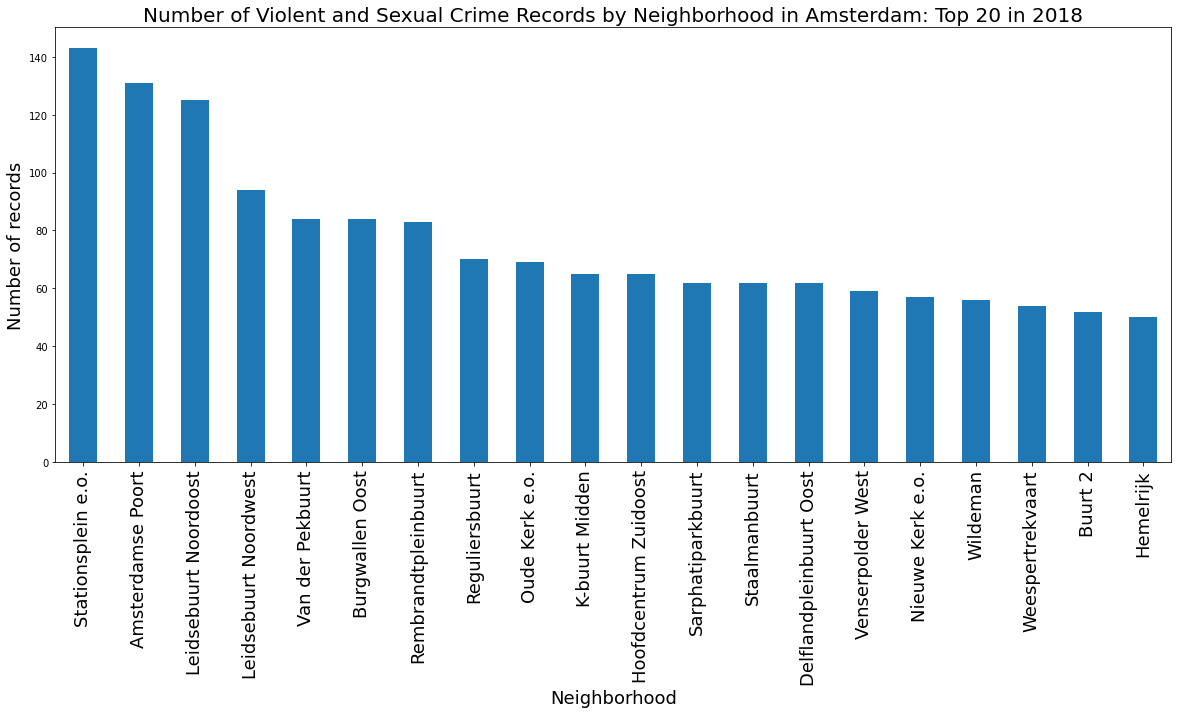

In [17]:
# Display the bar chart figure of the top 20 neighborhoods with the highest crime records
table.head(20).plot(kind= 'bar', legend=False, figsize=(20,8))
plt.title('Number of Violent and Sexual Crime Records by Neighborhood in Amsterdam: Top 20 in 2018', 
          fontweight = 30, fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 18)
plt.ylabel('Number of records', fontsize = 18)
plt.xticks(rotation = 90, fontsize = 18)
plt.show()

### Mapping

#### Generating a static choropleth map of the Netherlands using the violent and sexual crime data

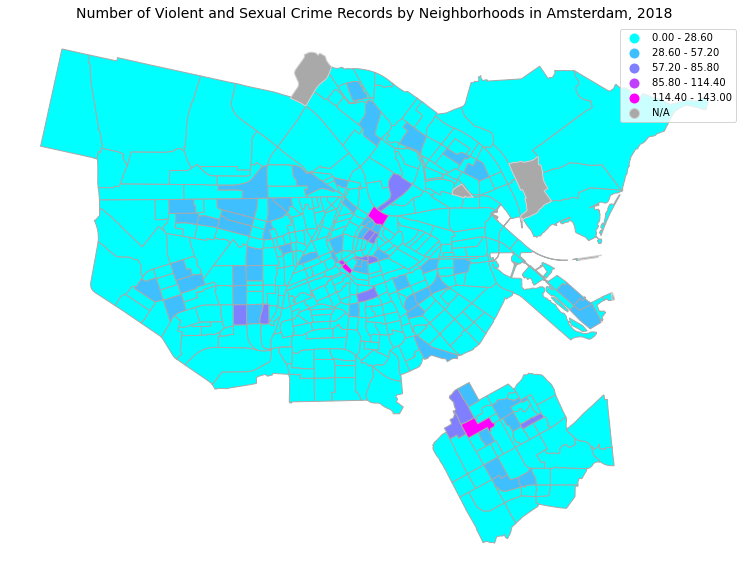

In [18]:
# Determine the size of the figure
fig, ax = plt.subplots(1, 1, figsize=[15,10])

# Create the map
cmap = plt.cm.cool           # for reverse of alternatives use (cmap = cmap.reversed())

nl_map = merged.plot(column='Total_violence_and_sexual_crimes', ax=ax, cmap = cmap, 
                     legend = True, edgecolor='darkgrey', scheme='equalinterval',
                     missing_kwds={'color': 'darkgrey', 'edgecolor': 'lightgrey', 
                                    'hatch': None, 'label': 'N/A'})
# Do not display information on the axis
ax.axis('off')

# Add a title
ax.set_title('Number of Violent and Sexual Crime Records by Neighborhoods in Amsterdam, 2018', 
             fontsize=14)

# Save figure in the directory and show
fig.savefig('Amsterdam_crime_map.png', dpi=300)
plt.show()

#### Generating an interactive map

In [19]:
# Convert the merged file (Geopandas Dataframe) to GeoJSON format
import json
#Read data to json.
merged_json = json.loads(merged.to_json())

#Convert to String like object.
json_data = json.dumps(merged_json)

In [ ]:
from bokeh.io import curdoc, output_notebook, show, output_file
from bokeh.plotting import figure, save
from bokeh.models import GeoJSONDataSource,  HoverTool, LinearColorMapper, ColorBar
from bokeh.palettes import RdYlBu11  as palette
from bokeh.layouts import row, column

  
# Input GeoJSON source
geosource = GeoJSONDataSource(geojson = json_data)

# Define a sequential color palette.
#palette = tuple(reversed(palette))

# Instantiate LinearColorMapper to linearly map the data in term of the sequence of colors.
color_mapper = LinearColorMapper(palette = palette)

# Add hover tool
hover = HoverTool(tooltips = [('Neigb','@Neigborhood'), ('Count', '@Total_violence_and_sexual_crimes')])

#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, width = 700, height = 30,
                     border_line_color=None, location = (0,0), orientation = 'horizontal')


#Create figure object.
p = figure(title = 'Number of Violent and Sexual Crime Records by Neighborhoods in Amsterdam, 2018', plot_height = 600 , 
           plot_width = 600, x_axis_location=None, y_axis_location=None, toolbar_location = None, tools = [hover])

p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource,fill_color = {'field' :'Total_violence_and_sexual_crimes', 'transform' : color_mapper},
          line_color = 'lightgrey', line_width = 0.5, fill_alpha = 1)

# Specify layout
p.add_layout(color_bar, 'below')

# Display plot inline in Jupyter notebook
output_notebook()

# output_file("Amsterdam_crime_interactive_map.html")
# save(p)

# Display plot
show(p)